In [1]:
import sys
import torch
import os
from os import makedirs
from argparse import ArgumentParser
from argparse import Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams, get_combined_args
import numpy as np
from scene import Scene, GaussianModel
from utils.general_utils import safe_state
import open3d as o3d
from utils.loss_utils import l1_loss, ssim
from utils.image_utils import psnr
from random import randint
from gaussian_renderer import render, network_gui
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import uuid
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_FOUND = True
except ImportError:
    TENSORBOARD_FOUND = False

def prepare_output_and_logger(args):    
    if not args.model_path:
        if os.getenv('OAR_JOB_ID'):
            unique_str=os.getenv('OAR_JOB_ID')
        else:
            unique_str = str(uuid.uuid4())
        args.model_path = os.path.join("./output/", unique_str[0:10])
        
    # Set up output folder
    print("Output folder: {}".format(args.model_path))
    os.makedirs(args.model_path, exist_ok = True)
    with open(os.path.join(args.model_path, "cfg_args"), 'w') as cfg_log_f:
        cfg_log_f.write(str(Namespace(**vars(args))))

    # Create Tensorboard writer
    tb_writer = None
    if TENSORBOARD_FOUND:
        tb_writer = SummaryWriter(args.model_path)
    else:
        print("Tensorboard not available: not logging progress")
    return tb_writer

def training_report(tb_writer, iteration, Ll1, loss, l1_loss, elapsed, testing_iterations, scene : Scene, renderFunc, renderArgs):
    if tb_writer:
        tb_writer.add_scalar('train_loss_patches/l1_loss', Ll1.item(), iteration)
        tb_writer.add_scalar('train_loss_patches/total_loss', loss.item(), iteration)
        tb_writer.add_scalar('iter_time', elapsed, iteration)

    # Report test and samples of training set
    if iteration in testing_iterations:
        torch.cuda.empty_cache()
        validation_configs = ({'name': 'test', 'cameras' : scene.getTestCameras()}, 
                              {'name': 'train', 'cameras' : [scene.getTrainCameras()[idx % len(scene.getTrainCameras())] for idx in range(5, 30, 5)]})

        for config in validation_configs:
            if config['cameras'] and len(config['cameras']) > 0:
                l1_test = 0.0
                psnr_test = 0.0
                for idx, viewpoint in enumerate(config['cameras']):
                    image = torch.clamp(renderFunc(viewpoint, scene.gaussians, *renderArgs)["render"], 0.0, 1.0)
                    gt_image = torch.clamp(viewpoint.original_image.to("cuda"), 0.0, 1.0)
                    if tb_writer and (idx < 5):
                        tb_writer.add_images(config['name'] + "_view_{}/render".format(viewpoint.image_name), image[None], global_step=iteration)
                        if iteration == testing_iterations[0]:
                            tb_writer.add_images(config['name'] + "_view_{}/ground_truth".format(viewpoint.image_name), gt_image[None], global_step=iteration)
                    l1_test += l1_loss(image, gt_image).mean().double()
                    psnr_test += psnr(image, gt_image).mean().double()
                psnr_test /= len(config['cameras'])
                l1_test /= len(config['cameras'])          
                print("\n[ITER {}] Evaluating {}: L1 {} PSNR {}".format(iteration, config['name'], l1_test, psnr_test))
                if tb_writer:
                    tb_writer.add_scalar(config['name'] + '/loss_viewpoint - l1_loss', l1_test, iteration)
                    tb_writer.add_scalar(config['name'] + '/loss_viewpoint - psnr', psnr_test, iteration)

        if tb_writer:
            tb_writer.add_histogram("scene/opacity_histogram", scene.gaussians.get_opacity, iteration)
            tb_writer.add_scalar('total_points', scene.gaussians.get_xyz.shape[0], iteration)
        torch.cuda.empty_cache()

In [9]:
torch.cuda.empty_cache()

def showGSRender(image):
    image_numpy = image.cpu().detach().numpy()
    # Transpose the dimensions to [height, width, channels]
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_numpy)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# #save as PLY for verification
def saveTensorAsPLY(points,colors, file_name):
    point_cloud_np = points.cpu().detach().numpy() 
    # Create an Open3D point cloud
    point_cloud_o3d = o3d.geometry.PointCloud()
    point_cloud_o3d.points = o3d.utility.Vector3dVector(point_cloud_np)
    point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors.cpu().detach().numpy())
    # Save the point cloud as a PLY file
    o3d.io.write_point_cloud(file_name, point_cloud_o3d)

def renderGSwithStats(viewpoint_cam, gaussians, pipeline):
    with torch.no_grad():
        print(viewpoint_cam.colmap_id)
        print(viewpoint_cam.R)
        print(viewpoint_cam.T)
        print(viewpoint_cam.camera_center)
        print(viewpoint_cam.projection_matrix)
        print(viewpoint_cam.image_width, viewpoint_cam.image_height)
        print(viewpoint_cam.world_view_transform.inverse()) # Gives C2W Transform Transpose
        print(viewpoint_cam.full_proj_transform)

        # Render
        bg = torch.ones((3), device="cuda")
        render_pkg = render(viewpoint_cam, gaussians, pipeline, bg)
        image, viewspace_point_tensor, visibility_filter, radii, raster_depth_map = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"], render_pkg["raster_depth"]
        showGSRender(image)

        print("Visibility Filter: ", visibility_filter.shape)
        print("Radii: ", radii.shape)
        print("Viewsapce Points: ", viewspace_point_tensor.shape)
        return raster_depth_map

In [5]:
# Setup Command line Arg
# sys.argv = ["train.py", "-s", "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data", "-r" ,"1"]
                        # "-m" , "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\output\\RGBD_Model"]

sys.argv = ["train.py", "-s", "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00", "-r" ,"1"]

parser = ArgumentParser(description='Progressice Gaussian Splatting')
model = ModelParams(parser)
pipeline = PipelineParams(parser)
op = OptimizationParams(parser)

# parser.add_argument('--ip', type=str, default="127.0.0.1")
# parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
# parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--save_iterations", nargs="+", type=int, default=[50, 100])
parser.add_argument("--test_iterations", nargs="+", type=int, default=[50, 100])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[50])
parser.add_argument("--start_checkpoint", type=str, default = None)

args = parser.parse_args(sys.argv[1:])

# Initialize system state (RNG)
# safe_state(args.quiet)

dataset, iteration, pipeline = model.extract(args), op.extract(args), pipeline.extract(args)

testing_iterations, saving_iterations, checkpoint_iterations, checkpoint, debug_from = args.test_iterations, args.save_iterations, args.checkpoint_iterations, args.start_checkpoint, args.debug_from

In [6]:
with torch.no_grad():
    # Initialize Gaussians with Zero Tensor
    gaussians = GaussianModel(dataset.sh_degree)
    # Load Actual Gaussians, Camera from PCD
    scene = Scene(dataset, gaussians, shuffle=False)

Loading ScanNet Scene
Reading Camera Info


100%|██████████| 15/15 [00:00<00:00, 1112.29it/s]

Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  1127666


In [7]:
# Get the viewpoint stack
viewpoint_stack = None
opt = op.extract(args)
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()
    
# viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

0
[[-9.55421e-01  1.19616e-01 -2.69932e-01]
 [ 2.95248e-01  3.88339e-01 -8.72939e-01]
 [ 4.08000e-04 -9.13720e-01 -4.06343e-01]]
[2.65583  2.981598 1.368648]
tensor([2.6558, 2.9816, 1.3686], device='cuda:0')
tensor([[ 1.8050,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.4114,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device='cuda:0')
1296 968
tensor([[-9.5542e-01,  2.9525e-01,  4.0771e-04,  0.0000e+00],
        [ 1.1962e-01,  3.8834e-01, -9.1372e-01, -0.0000e+00],
        [-2.6993e-01, -8.7294e-01, -4.0634e-01,  0.0000e+00],
        [ 2.6558e+00,  2.9816e+00,  1.3686e+00,  1.0000e+00]], device='cuda:0')
tensor([[-1.7245e+00,  2.8845e-01, -2.6996e-01, -2.6993e-01],
        [ 5.3291e-01,  9.3645e-01, -8.7303e-01, -8.7294e-01],
        [ 7.3643e-04, -2.2034e+00, -4.0638e-01, -4.0634e-01],
        [ 2.9901e+00, -5.4255e-01,  3.8662e+00,  3.8758e+00]], device='cuda:0')
Raster Depth Map:  torch.Size([968, 1296])


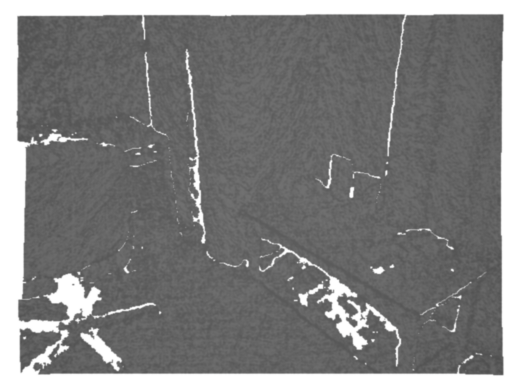

Visibility Filter:  torch.Size([1127666])
Radii:  torch.Size([1127666])
Viewsapce Points:  torch.Size([1127666, 3])


In [10]:
# Redner the first viewpoint
raster_depth_map = renderGSwithStats(viewpoint_stack[0], gaussians, pipeline)

In [15]:
torch.min(raster_depth_map), torch.max(raster_depth_map)

# Mask the max depth
mask = raster_depth_map == 1000000
raster_depth_map[mask] = 0
torch.min(raster_depth_map), torch.max(raster_depth_map)

(tensor(0., device='cuda:0'), tensor(3.0560, device='cuda:0'))

In [ ]:
# ply_path = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data\\ply"
ply_path = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\ply"

ply_files = os.listdir(ply_path)

def loadPLY(ply_file):
       pcd = o3d.io.read_point_cloud(ply_file)
       points = np.asarray(pcd.points)
       colors = np.asarray(pcd.colors)
       points = torch.from_numpy(points).float().cuda()
       colors = torch.from_numpy(colors).float().cuda()
       return points, colors

# 2D Rasterization
def getPixelIndicesfromPLYPerspective(points, colors,  viewpoint_cam, sub_pixel_level=1):
       # Get Projection Matrix
       P = viewpoint_cam.full_proj_transform

       # Project points using projection matrix P in torch cuda and get result in NDC
       points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
       
       projected_points_homogeneous = torch.matmul(points_homogeneous, P.t()) # Clip space coordinates


       print(points_homogeneous.shape, projected_points_homogeneous.shape)
       # print('Clip Space: ', projected_points_homogeneous.shape, projected_points_homogeneous.min(), projected_points_homogeneous.max())

       # # Filter points outside clip space
       # mask = (projected_points_homogeneous[:, 0] >= -1) & (projected_points_homogeneous[:, 0] < 1) & \
       #        (projected_points_homogeneous[:, 1] >= -1) & (projected_points_homogeneous[:, 1] < 1 ) # & \
              # (projected_points_homogeneous[:, 2] >= -1) & (projected_points_homogeneous[:, 2] < 1) // Removes points closer to camera so not included
       # projected_points_homogeneous = projected_points_homogeneous[mask]

       # Clip Space / Homogenous to NDC
       assert projected_points_homogeneous.shape[1] == 4
       # Extract x, y, z, w from the tensor
       x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
       x_ndc = x / w
       y_ndc = y / w
       z_ndc = z / w
       projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)

       # print('NDC: ', projected_points_NDC.shape, projected_points_NDC.min(), projected_points_NDC.max())

       # NDC to Image Space [-1,1] to [0,1]
       projected_points_IS = (projected_points_NDC + 1) / 2

       # Filter points outside image space
       mask = (projected_points_IS[:, 0] >= 0) & (projected_points_IS[:, 0] < 1) & \
              (projected_points_IS[:, 1] >= 0) & (projected_points_IS[:, 1] < 1 ) # & \
              # (projected_points_IS[:, 2] >= 0) & (projected_points_IS[:, 2] < 1)
       # projected_points_IS = projected_points_IS[mask]
       # points_filtered = points[mask]
       # colors_filtered = colors[mask]

       # print(projected_points_IS.shape, projected_points_IS.min(), projected_points_IS.max())

       # Get image width and height
       img_width, img_height = viewpoint_cam.image_width, viewpoint_cam.image_height
       # Calculate effective pixel width and height based on the sub-pixel variable
       effective_pixel_width, effective_pixel_height = img_width // sub_pixel_level, img_height // sub_pixel_level
       # Get pixel coordinates
       pixel_coordinates = projected_points_IS[:,:2] * torch.tensor([effective_pixel_width, effective_pixel_height], device=points.device).float()
       pixel_indices = torch.floor(pixel_coordinates).to(torch.int)


       # Create an empty image for visualization
       img = torch.zeros((968, 1296, 3), dtype=torch.uint8, device=points.device)
       pixel_indices_long = pixel_indices.to(torch.long)
       pixel_indices_long = torch.clamp(pixel_indices_long, 0, img_width - 1)
       pixel_indices_long = torch.cat((pixel_indices_long[:, 1:], pixel_indices_long[:, :1]), dim=1)  # Swap x and y for indexing
       colors_uint8 = (colors * 255).to(torch.uint8)
       img[pixel_indices_long[:, 1], pixel_indices_long[:, 0]] = colors_uint8
       img_cpu = img.cpu().detach().numpy()
       plt.imshow(img_cpu.astype(int))  # Convert the image to int for display
       plt.show()

       # print(pixel_indices.shape, pixel_indices.min(), pixel_indices.max())
       # return points_filtered,colors_filtered,pixel_indices

In [ ]:
viewpoint_cam = viewpoint_stack[0]
viewpoint_cam.intrinsics 

In [ ]:
def showRasterizedImageComp(image1, image2):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image on the left subplot
    axes[0].imshow(image1)
    axes[0].set_title('Current PC Image')

    # Display the second image on the right subplot
    axes[1].imshow(image2)
    axes[1].set_title('Global PC Raster')

    # Hide the axes ticks
    for ax in axes:
        ax.axis('off')

    # Show the plot
    plt.show()

In [ ]:
def showTensorImage(image):
    raster = image.cpu().numpy()
    plt.imshow(raster.astype(int))
    plt.show()
    

def showRasterizedImage(u,v, colors, rgb_height=968, rgb_width=1296):
    # print(u.shape, v.shape, colors.shape)
    u = u.cpu().detach().numpy()
    v = v.cpu().detach().numpy()
    colors = colors.cpu().detach().numpy()

    assert len(u) == len(v) == len(colors)
    image_size = (rgb_height, rgb_width, 3)
    raster = np.zeros(image_size, dtype=np.float32)

    # print(np.shape(u), np.shape(v), np.shape(colors), np.shape(raster))

    raster[v, u] = colors
    # Clip values to ensure they are in the valid range [0, 1]
    image = np.clip(raster, 0, 1)
    plt.imshow(raster)
    plt.show()
    return image

def showFilterMaskImage(indices_not_in_global, rgb_height=968, rgb_width=1296):
    u = indices_not_in_global[:,0]
    v = indices_not_in_global[:,1]
    u = u.cpu().detach().numpy()
    v = v.cpu().detach().numpy()
    assert len(u) == len(v)
    image_size = (rgb_height, rgb_width, 3)
    raster = np.zeros(image_size, dtype=np.float32)
    raster[v, u] = 1
    plt.imshow(raster)
    plt.show()
    

def getPixelIndicesfromPLY(points, colors,  viewpoint_cam, sub_pixel_level=1):
    intrinsics = viewpoint_cam.intrinsics
    c_x = intrinsics[0,2]
    c_y = intrinsics[1,2]
    f_x = intrinsics[0,0]
    f_y = intrinsics[1,1]
    W2C = viewpoint_cam.world_view_transform

    # print('Intrinsics: ', c_x, c_y, f_x, f_y)

    # Project points using projection matrix P in torch cuda and get result in NDC

    points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
    # print(points_homogeneous.shape, colors.shape, W2C)
    
    points_camera_homogeneous = torch.matmul(points_homogeneous, W2C) # Clip space coordinates

    # print(projected_points_homogeneous.shape)
    # print(projected_points_homogeneous[0])
    X = points_camera_homogeneous[:, 0]
    Y = points_camera_homogeneous[:, 1]
    Z = points_camera_homogeneous[:, 2]

    # print('Depth: ',  Z.min(), Z.max())

    # W = projected_points_homogeneous[:, 3]
    u = X * f_x / Z + c_x
    v = Y * f_y / Z + c_y
    u = u.to(torch.int16)
    v = v.to(torch.int16)

    # Filter points outside image space
    img_width, img_height = viewpoint_cam.image_width, viewpoint_cam.image_height
    image_space_mask = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height )
    u = u[image_space_mask]
    v = v[image_space_mask]
    colors_filtered = colors[image_space_mask]
    points_filtered = points[image_space_mask]

    # raster = showRasterizedImage(u,v, colors_filtered, img_height, img_width)
    try:
        # print(u.shape, v.shape, colors_filtered.shape)
        raster = torch.zeros((img_height, img_width, 3), dtype=torch.uint8 , device=points.device)
        IS_point_positions = torch.zeros((img_height, img_width, 3), dtype=torch.float16 , device=points.device)
        IS_point_colors = torch.zeros((img_height, img_width, 3), dtype=torch.float16 , device=points.device)
        
        # Create Indices
        u_long = u.to(torch.long)
        v_long = v.to(torch.long)
        # Store Points and Colors
        raster[v_long, u_long] = (colors_filtered * 255).to(torch.uint8)
        IS_point_positions[v_long, u_long] = points_filtered.to(torch.float16)
        IS_point_colors[v_long, u_long] = colors_filtered.to(torch.float16)
        
    except Exception as e:
        print(f"Error: {e}")

    # pixel_indices_long = torch.clamp(pixel_indices_long, 0, img_width - 1)
    # pixel_indices_long = torch.cat((pixel_indices_long[:, 1:], pixel_indices_long[:, :1]), dim=1)  # Swap x and y for indexing
    # colors_uint8 = (colors * 255).to(torch.uint8)
    # img[pixel_indices_long[:, 1], pixel_indices_long[:, 0]] = colors_uint8

    pixel_indices = torch.stack((u,v), dim=1)

    # print(pixel_indices.shape)

    # # print(pixel_indices.shape, pixel_indices.min(), pixel_indices.max())
    return points_filtered,colors_filtered,pixel_indices, raster, IS_point_positions, IS_point_colors

In [ ]:
# Add new points from PLY
sub_pixel_level = 1

global_points = None
global_colors = None

for i in tqdm(range(len(viewpoint_stack))):
# for i in tqdm(range(10)): 
    viewpoint_cam = viewpoint_stack[i]
    # Check if PLY file exists
    ply_file_name = viewpoint_cam.colmap_id + ".ply"
    filtered_ply_file_name = viewpoint_cam.colmap_id + "_filtered.ply"

    # print(ply_file_name)

    # if ply_file_name not in ply_files:
    #     continue

    ply_file_path = os.path.join(ply_path, ply_file_name)
    
    pcd_points, pcd_colors = loadPLY(ply_file_path)
    filtered_points, filtered_colors,  indices, current_raster, raster_point_positions, raster_point_colors = getPixelIndicesfromPLY(pcd_points, pcd_colors, viewpoint_cam)

    # raster = current_raster.cpu().numpy()
    # plt.imshow(raster.astype(int))
    # plt.show()
    
    # print('Indices:', indices.shape, indices.min(), indices.max())

    # # Load Initial Points
    if global_points is None:
        print("Initialized with points from first Frame")
        global_points = filtered_points
        global_colors = filtered_colors
    else:
        global_filtered_points, global_filtered_colors, global_pixel_indices, global_raster, _ , _ = getPixelIndicesfromPLY(global_points,global_colors, viewpoint_cam)

        global_black_mask = torch.all(global_raster == 0, dim=2, keepdim=True)
        # Apply Mask to point positions that are black
        raster_point_positions_masked = raster_point_positions.view(-1, 3) * global_black_mask.view(-1, 1)
        current_raster_masked = raster_point_colors.view(-1, 3) * global_black_mask.view(-1, 1)

        # Find points which have all 0 values
        invalid_points_mask = torch.all(raster_point_positions_masked == 0, dim=1, keepdim=True)

        raster_point_positions_filtered = raster_point_positions_masked[~invalid_points_mask.view(-1)]
        current_raster_filtered = current_raster_masked[~invalid_points_mask.view(-1)]

        saveTensorAsPLY(raster_point_positions_filtered,current_raster_filtered, filtered_ply_file_name)
        # Append to global points
        global_points = torch.cat((global_points, raster_point_positions_filtered), dim=0)
        global_colors = torch.cat((global_colors, current_raster_filtered), dim=0)
        
saveTensorAsPLY(global_points,global_colors, "Global.ply")        

In [ ]:
# # Visualize Global Mask
# global_black_mask = torch.all(global_raster == 0, dim=2, keepdim=True)
# # Apply Mask to point positions that are black
# raster_point_positions_masked = raster_point_positions.view(-1, 3) * global_black_mask.view(-1, 1)
# current_raster_masked = current_raster.view(-1, 3) * global_black_mask.view(-1, 1)

# # Find points which have all 0 values
# invalid_points_mask = torch.all(raster_point_positions_masked == 0, dim=1, keepdim=True)

# raster_point_positions_filtered = raster_point_positions_masked[~invalid_points_mask.view(-1)]
# current_raster_filtered = current_raster_masked[~invalid_points_mask.view(-1)]

# print(raster_point_positions_masked.shape, current_raster_masked.shape)
# print(raster_point_positions_filtered.shape, current_raster_filtered.shape)

# showTensorImage(global_raster)
# showTensorImage(current_raster)
# showTensorImage(current_raster_masked.view(current_raster.shape))

In [ ]:
# Train Loop
first_iter = 0
tb_writer = prepare_output_and_logger(dataset)
gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians)
gaussians.training_setup(opt)
if checkpoint:
    (model_params, first_iter) = torch.load(checkpoint)
    gaussians.restore(model_params, opt)

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

iter_start = torch.cuda.Event(enable_timing = True)
iter_end = torch.cuda.Event(enable_timing = True)

viewpoint_stack = None
ema_loss_for_log = 0.0
progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")
first_iter += 1
for iteration in range(first_iter, opt.iterations + 1):        
    if network_gui.conn == None:
        network_gui.try_connect()
    while network_gui.conn != None:
        try:
            net_image_bytes = None
            custom_cam, do_training, pipeline.convert_SHs_python, pipeline.compute_cov3D_python, keep_alive, scaling_modifer = network_gui.receive()
            if custom_cam != None:
                net_image = render(custom_cam, gaussians, pipeline, background, scaling_modifer)["render"]
                net_image_bytes = memoryview((torch.clamp(net_image, min=0, max=1.0) * 255).byte().permute(1, 2, 0).contiguous().cpu().numpy())
            network_gui.send(net_image_bytes, dataset.source_path)
            if do_training and ((iteration < int(opt.iterations)) or not keep_alive):
                break
        except Exception as e:
            network_gui.conn = None

    iter_start.record()

    gaussians.update_learning_rate(iteration)

    # Every 1000 its we increase the levels of SH up to a maximum degree
    if iteration % 1000 == 0:
        gaussians.oneupSHdegree()

    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene.getTrainCameras().copy()
    viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

    # Render
    if (iteration - 1) == debug_from:
        pipeline.debug = True

    bg = torch.rand((3), device="cuda") if opt.random_background else background

    render_pkg = render(viewpoint_cam, gaussians, pipeline, bg)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

    # Loss
    gt_image = viewpoint_cam.original_image.cuda()
    Ll1 = l1_loss(image, gt_image)
    loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
    loss.backward()

    iter_end.record()

    with torch.no_grad():
        # Progress bar
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 10 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # Log and save
        # training_report(tb_writer, iteration, Ll1, loss, l1_loss, iter_start.elapsed_time(iter_end), testing_iterations, scene, render, (pipeline, background))
        if (iteration in saving_iterations):
            print("\n[ITER {}] Saving Gaussians".format(iteration))
            scene.save(iteration)

        # Densification
        if iteration < opt.densify_until_iter:
            # Keep track of max radii in image-space for pruning
            gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
            gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

            if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
                size_threshold = 20 if iteration > opt.opacity_reset_interval else None
                gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)
            
            if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
                gaussians.reset_opacity()

        # Optimizer step
        if iteration < opt.iterations:
            gaussians.optimizer.step()
            gaussians.optimizer.zero_grad(set_to_none = True)

        if (iteration in checkpoint_iterations):
            print("\n[ITER {}] Saving Checkpoint".format(iteration))
            torch.save((gaussians.capture(), iteration), scene.model_path + "/chkpnt" + str(iteration) + ".pth")
